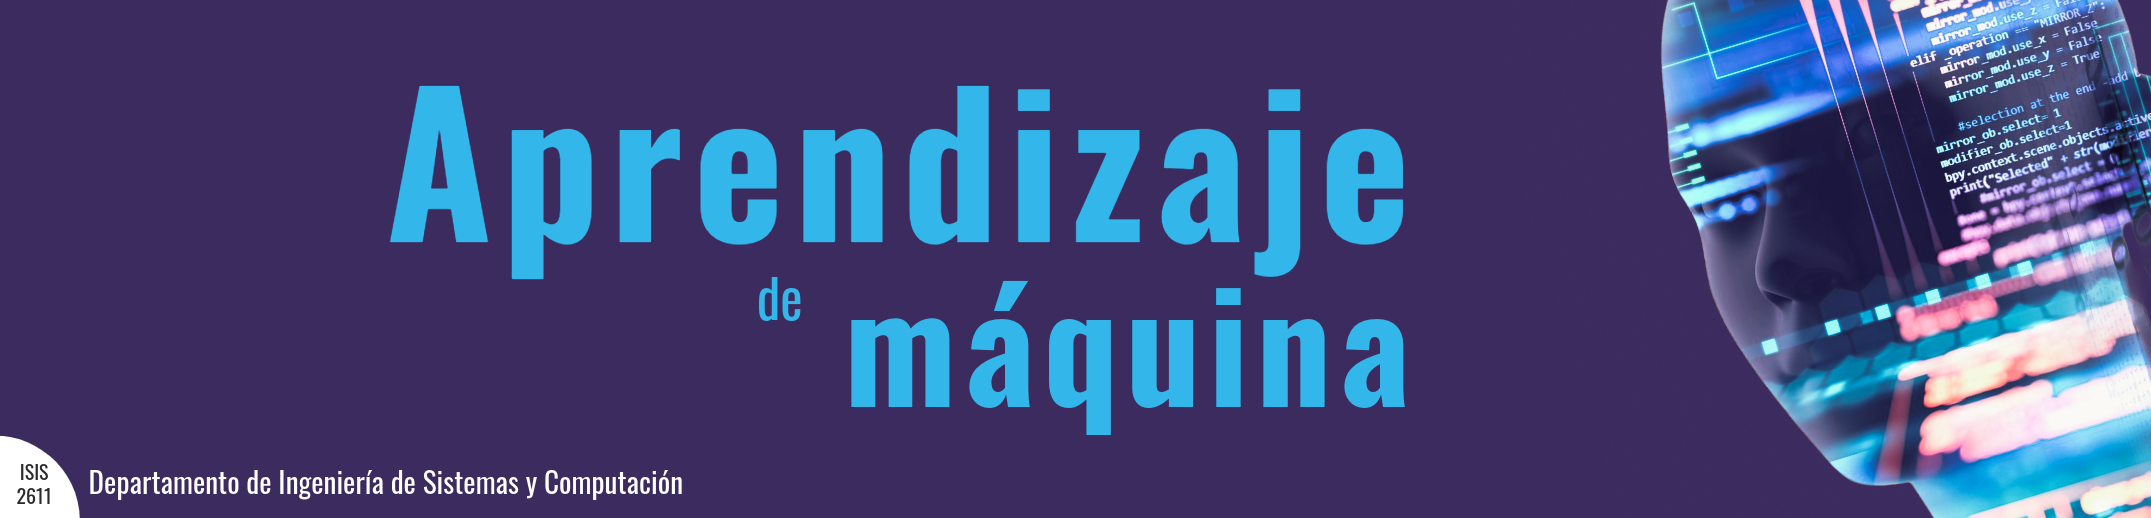


En este notebook tutorial aprenderás a construir un modelo de regresión lineal. El conjunto de datos que usaremos recopila información sobre la venta de inmuebles, la cual incluye variables que describen las características principales de cada uno y el precio final de venta. 

Este notebook estará compuesto de las siguientes partes:
1. Importar las librerías que usaremos.
2. Cargar el conjunto de datos.
3. Limpieza de datos.
4. Particion de los datos en entrenamiento y test.
5. Construcción de un pipeline de perparación de datos.
6. Entrenamiento del modelo de regresión lineal.
7. Estimación de la capacidad de generalización del modelo.
8. Verificación de los supuestos de la regresión lineal.s sector.

## 1. Importación de las librerías

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.formula.api import ols

from statsmodels.stats.diagnostic import linear_rainbow
from scipy.stats import ttest_1samp
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro

## 2. Carga de los datos

Para este notebook seguiremos usando los datos de Venta de Inmuebles (los mismos que hemos venido trabajando anteriormente). Como primer paso usaremos la función de Pandas `read_excel()`. El archivo será almacenado nuevamente en el subdirectorio `data`. Si el conjunto tiene una ubicación diferente, puedes cambiar la ruta al interior de los paréntesis o modificar la ubicación del archivo.

In [137]:
datos_inmuebles = pd.read_excel('./data/Venta_Inmuebles.xlsx')

In [138]:
data = datos_inmuebles.copy()

## 3. Limpieza inicial de datos.



A partir de los problemas de calidad identificados previamente, es necesario decidir en qué etapa del proceso aplicar las operaciones de limpieza y transformación. Aunque la mayoría de estas se realizarán sobre el conjunto de entrenamiento mediante un pipeline, el problema de unicidad requiere un tratamiento previo sobre el conjunto de datos completo. En la práctica anterior se identificaron registros con el mismo `Id` que representaban la misma propiedad, diferenciándose únicamente en el precio y la fecha, lo que corresponde a múltiples valorizaciones en el tiempo. Si esta limpieza se realizara después de la división en entrenamiento y prueba, podrían quedar representaciones incoherentes de una misma entidad distribuidas entre ambos conjuntos, lo que afecta la correcta definición de la **unicidad** de análisis y puede introducir evaluaciones artificialmente optimistas. Por ello, la única operación de limpieza que se aplicará inicialmente al conjunto general será la de unicidad, antes de separar los datos.

In [139]:
data["Fecha"] = pd.to_datetime(data["Fecha"], errors="coerce")

# Ordenar por Id y Fecha
data = data.sort_values(["Id", "Fecha"])

# Para cada Id nos quedamos con el registro más reciente
data = data.drop_duplicates(subset="Id", keep="last")

Este código cambia el tipo de dato de la variable `Fecha`, lo cual es absolutamente permitido (ya que cambia el tipo, no el formato). Este cambio se hace para comparar las fechas y quedarnos con los registros más actualizados que compartan un `Id`.


A continuación, verificamos si todavía tenemos más de un registro con el mismo `Id`:

In [140]:
# ids duplicados
dup_counts = (data['Id'].value_counts()
                        .loc[lambda s: s > 1]
                        .sort_values(ascending=False))
for id_, n in dup_counts.items():
    print(f"Id={id_} → {n} apariciones")

if dup_counts.sum() == 0:
    print("No hay duplicados")

No hay duplicados


Como vemos, ya cumplimos con la **unicidad** (no tenemos registros duplicados, ni con el mismo `Id`. Ahora si, ya podemos pasar a separar el conjunto en train y test.

 ## 4. Partición de los datos.

Una vez realizadas las tareas previas de limpieza, podemos separar los datos en dos conjuntos: entrenamiento (**train**), que se utilizará para entrenar el modelo de Regresión Lineal, y prueba (**test**), destinado a evaluar su desempeño. En esta etapa también se definen las variables del modelo, donde la variable objetivo o dependiente es el `Precio`, y el resto de las variables se consideran inicialmente como variables predictoras, aclarando que esta selección podrá ajustarse en etapas posteriores del análisis.

In [141]:
target = "Precio"
X = data.drop(columns=[target])
y = data[target]

En el código anterior realizamos la separación de las variables, donde `X` contiene todas las variables independientes que servirán como insumo para predecir el valor de la variable objetivo. A continuación, verifiquemos que esta separación se haya realizado correctamente.

In [142]:
X

,Id,Fecha,Cuartos,Baños,AreaHabitable,AreaLote,Pisos,FrenteMar,Vista,Condición,Calificación,AreaSuperior,AreaBase,Años,Renovación,CodigoPostal,Latitud,Longitud,AreaHabitable15,AreaLote15
2497,1000102,2015-04-22,6,3.00,2400,9373,2.0,NO,0,3,7.0,2400,0,1991,0,98002,473262.0,-122214.0,2060,7316
6735,1200019,2014-05-08,4,1.75,2060,26036,1.0,NO,0,4,8.0,1160,900,1947,0,98166,474444.0,-122351.0,2590,21891
8411,1200021,2014-08-11,3,1.00,1460,43000,1.0,NO,0,3,7.0,1460,0,1952,0,98166,474434.0,-122347.0,2250,20023
8809,2800031,2015-04-01,3,1.00,1430,7599,1.5,NO,0,4,6.0,1010,420,1930,0,98168,474783.0,-122265.0,1290,10320
3557,3600057,2015-03-19,4,2.00,1650,3504,1.0,NO,0,3,7.0,760,890,1951,2013,98144,475803.0,-122294.0,1480,3504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16737,9842300095,2014-07-25,5,2.00,1600,4168,1.5,NO,0,3,7.0,1600,0,1927,0,98126,475297.0,-122381.0,1190,4168
3260,9842300485,2015-03-11,2,1.00,1040,7372,1.0,NO,0,5,7.0,840,200,1939,0,98126,475285.0,-122378.0,1930,5150
7621,9842300540,2014-06-24,3,1.00,1100,4128,1.0,NO,0,4,7.0,720,380,1942,0,98126,475296.0,-122379.0,1510,4538
20979,9895000040,2014-07-03,2,1.75,1410,1005,1.5,NO,0,3,9.0,900,510,2011,0,98027,475446.0,-122018.0,1440,1188


In [143]:
y

2497     300000.0
6735     647500.0
8411     400000.0
8809     235000.0
3557     402500.0
           ...   
16737    365000.0
3260     380000.0
7621     339000.0
20979    399900.0
15951    268950.0
Name: Precio, Length: 21436, dtype: float64


Una vez confirmada la correcta separación de las variables, estamos listos para dividir el conjunto de datos en entrenamiento (**train**) y prueba (**test**). Esta decisión depende del modelador; en este caso, se utilizará el 80 % de los datos para entrenar el modelo y el 20 % restante para evaluarlo. Esta proporción permite contar con suficiente información para el aprendizaje, al tiempo que se reserva un conjunto de datos no visto para medir el rendimiento en nuevos ejemplos. Para realizar esta división se emplea la función `train_test_split()`, que recibe las variables explicativas `X`, la variable objetivo `y`, la proporción del conjunto de prueba (`test_size=0.2`) y el parámetro `random_state`, que garantiza que la partición sea reproducible y que los resultados puedan compararse entre ejecuciones.


In [144]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1)


Adicionalmente, podemos ver el tamaño de cada conjunto:


In [145]:
X_train.shape, y_train.shape

((17148, 20), (17148,))

In [146]:
X_test.shape, y_test.shape

((4288, 20), (4288,))

## 5. Construcción del pipeline

Antes de construir el `Pipeline`, es importante comprender su propósito. Un `Pipeline` permite encadenar de forma ordenada todas las etapas de un modelo, desde la limpieza y transformación de los datos hasta el entrenamiento, garantizando que estos pasos se ejecuten siempre en el mismo orden y de la misma manera. Esto permite aplicar exactamente las mismas transformaciones tanto a los datos de entrenamiento como a los de prueba, favoreciendo la consistencia y la capacidad de generalización del modelo. Para su construcción, el primer paso es definir claramente las etapas del flujo y las variables que participarán en la predicción. 
Como primer paso, vamos a pensar en las columnas que no deseamos incluir en la predicción, aquellas que consideramos que no aportan información significativa para estimar el `Precio`. En este caso serán las variables `Id`, `Fecha` y `CodigoPostal`.

In [147]:
cols_to_drop = ["Id", "Fecha", "CodigoPostal"]

def drop_columns(df):
    return df.drop(columns=cols_to_drop, errors="ignore")

dropper = FunctionTransformer(drop_columns)


Adicionalmente, es fundamental identificar las columnas numéricas y categóricas, ya que el tipo de variable determina los pasos de transformación que se aplicarán a cada una.


In [148]:
numeric_features = [
    "Cuartos", "Baños", "AreaHabitable", "AreaLote", "Pisos",
    "Vista", "Condición", "Calificación", "AreaSuperior",
    "AreaBase", "Años", "Renovación", "Latitud", "Longitud",
    "AreaHabitable15", "AreaLote15"
]

categorical_features = [
    "FrenteMar"
]


Una vez separadas las columnas según su tipo de dato, se definen las transformaciones necesarias para el modelo de regresión lineal. En el caso de las variables numéricas, se aplicarán las siguientes operaciones:

- Tratamiento de valores faltantes (completitud): el modelo de regresión lineal no puede trabajar con valores nulos, por lo que estos se imputarán utilizando la media de cada variable, calculada únicamente a partir de los datos de entrenamiento (utilizando `SimpleImputer`). Esto permite conservar un valor representativo de la distribución original sin introducir sesgos.

- Escalamiento de variables numéricas: se utilizará `StandardScaler()` para estandarizar las variables numéricas, llevándolas a una escala comparable (media cercana a 0 y desviación estándar igual a 1). Esto es especialmente importante cuando las variables presentan diferentes unidades y rangos, ya que algunos algoritmos de aprendizaje automático son sensibles a la escala de los datos y requieren este tipo de transformación.


In [149]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)


Para las variables categóricas se aplicará una transformación `One-Hot Encoding`, ya que el modelo solo puede operar con valores numéricos y no con categorías. En lugar de asignar códigos arbitrarios a las categorías —lo que introduciría un orden inexistente—, el One-Hot Encoding crea una columna binaria por cada categoría, indicando con valores 0 o 1 si un registro pertenece a ella. De esta manera, la información categórica se convierte en una representación numérica adecuada para el modelo, sin imponer relaciones artificiales entre las categorías. En el OneHotEncoder, el parámetro handle_unknown="ignore" permite manejar correctamente categorías no vistas durante el entrenamiento, evitando errores cuando el pipeline se aplica a datos nuevos. Por su parte, drop="if_binary" elimina una de las columnas generadas cuando la variable categórica es binaria, reduciendo la redundancia y evitando problemas de multicolinealidad en modelos lineales.


In [150]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
])


Para abordar el atributo de calidad **validez**, se definió una transformación sobre la variable `Condición`, que presentaba valores fuera del rango $[0,4]$, como valores negativos y dígitos repetidos. Según la validación con el negocio, estos casos se corrigieron usando el valor absoluto y reduciendo los dígitos repetidos a uno solo (por ejemplo, 44 → 4), mediante una función integrada en el pipeline.


In [151]:
def limpiar_condicion(df):
    df = df.copy()
    df["Condición"] = df["Condición"].abs()
    df["Condición"] = df["Condición"].astype(str).str[0].astype(int)
    return df

limpieza_condicion = FunctionTransformer(limpiar_condicion)


Para abordar el atributo de **consistencia** en la variable `FrenteMar`, se definió una transformación personalizada que unifica los valores llevándolos a mayúsculas. De este modo, representaciones equivalentes como "no", " No " o "NO" quedan normalizadas en un único formato. Esta función se integró al Pipeline mediante FunctionTransformer, permitiendo su aplicación automática dentro del flujo de procesamiento.


In [152]:
def normalizar_frentemar(df):
    df = df.copy()
    df["FrenteMar"] = df["FrenteMar"].str.upper()
    return df

normalizar_frentemar_tr = FunctionTransformer(normalizar_frentemar)


En este paso usamos `ColumnTransformer` para aplicar diferentes transformaciones según el tipo de variable. La idea es decirle explícitamente al modelo qué hacer con las columnas numéricas y qué hacer con las categóricas, dentro de un solo bloque de preprocesamiento.


In [153]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


Ahora definimos `pipeline_regresion` como un pipeline completo de extremo a extremo, que encadena todas las transformaciones sobre los datos junto con el modelo de regresión lineal. Se tienen todos los pasos que definimos anteriormente, secuenciadas en el orden que queremos que se ejecute:


In [154]:
pipeline_regresion = Pipeline(steps=[
    ("dropper", dropper),
    ("limpiar_condicion", limpieza_condicion),
    ("normalizar_frentemar", normalizar_frentemar_tr),
    ("preprocesamiento", preprocessor),
])

En esta etapa podemos visualizar la estructura de nuestro pipeline:

In [155]:
from sklearn import set_config
set_config(display="diagram")

In [156]:
pipeline_regresion

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('dropper', ...), ('limpiar_condicion', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function dro...001D21629EDA0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword argume

Este pipeline se ajusta a X_train y se utiliza para transformar este conjunto de datos. Vamos a utilizar otra variable para no afectar el conjunto de entrenamiento original.

In [157]:
Xt_train = pipeline_regresion.fit_transform(X_train)

Un paso importante acá es tener en cuenta que, cuando se aplica la transformación `One-Hot`, se genera un `numpy array`. Esto pasa con otros transformadores también. Tenemos entonces que transformar nuestros datos de nuevo en un dataframe.

In [158]:
feature_names = pipeline_regresion.named_steps["preprocesamiento"].get_feature_names_out()
Xt_train_df = pd.DataFrame(
    Xt_train.toarray() if hasattr(Xt_train, "toarray") else Xt_train,
    columns=feature_names,
    index=X_train.index
)

## 6. Entrenamiento del modelo de regresión lineal.

Ahora, pasamos a entrenar el modelo con el conjunto de entrenamiento. Usamos la función `.fit()` para entrenar y aprender los parámetros con base en los datos. Primero, creamos un objeto de la clase `LinearReEgression`.

In [159]:
Modelo = LinearRegression()

In [160]:
Modelo.fit(Xt_train_df,y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


A continuación, se solicita al modelo que genere las predicciones sobre el conjunto de entrenamiento.

In [161]:
y_train_pred = Modelo.predict(Xt_train_df)

### Validación del modelo

Para evaluar el desempeño del modelo, analizamos qué tan alejadas están las predicciones respecto a los valores reales de la variable objetivo.

**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

MAE mide el error promedio de las predicciones como el valor absoluto de la diferencia entre los valores reales y los estimados. Se interpreta en las mismas unidades de la variable objetivo y no penaliza de forma desproporcionada los errores grandes.

In [162]:
mae_train = mean_absolute_error(y_train, y_train_pred)
print("MAE  train:", mae_train)

MAE  train: 140066.84566670723


**Root Mean Squeared Error (RMSE)**

$$ RMSE =  \sqrt{{1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } }$$

El RMSE refleja el error promedio de las predicciones en las mismas unidades de la variable objetivo. Al derivarse del MSE, hereda su mayor penalización a los errores grandes, pero ofrece una interpretación más directa de la magnitud del error.

In [163]:
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("RMSE train:", rmse_train)

RMSE train: 216383.79145314783


**Coeficiente de  determinación R^2**

$$ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $$

El coeficiente de determinación (R²) indica qué proporción de la variabilidad de la variable objetivo es explicada por el modelo. En este caso, expresa el porcentaje de la variación en los precios que puede atribuirse a las variables predictoras. Su valor suele estar entre 0 y 1, donde valores cercanos a 1 indican un mejor ajuste del modelo. Un valor cercano a 0 sugiere que el modelo explica muy poca variabilidad, mientras que valores negativos indican que el modelo tiene un desempeño peor que un modelo trivial que predice siempre el valor medio de la variable objetivo.

In [164]:
r2_train = r2_score(y_train, y_train_pred)
print("R²   train:", r2_train)

R²   train: 0.6437895872500702



Con base en los resultados obtenidos sobre el conjunto de entrenamiento, el modelo de regresión lineal explica aproximadamente el 65 % de la variabilidad en el precio de los inmuebles. El valor del RMSE se sitúa alrededor de 210.000 unidades monetarias, lo que sugiere que el error típico en las estimaciones del modelo se encuentra, en promedio, en ese orden de magnitud. SE puede decir que, en conjunto, estos resultados indican que el modelo aprende patrones razonables a partir de los datos de entrenamiento, sin evidenciar un ajuste perfecto, y constituyen un punto de partida para evaluar posteriormente su comportamiento sobre el conjunto de prueba.


## 7. Estimación de la capacidad de generalización del modelo.

A continuación, evaluamos el modelo utilizando el conjunto de prueba (**test**), lo que permite analizar su capacidad de generalización al enfrentarse a datos no vistos durante el entrenamiento. Primero, se utiliza `pipeline_regresion.transform(X_test)`, que aplica automáticamente las transformaciones aprendidas en la fase de entrenamiento. En esta etapa se emplea exclusivamente el método `.transform()`, ya que no se vuelven a ajustar el paso de preparación de datos al test.


In [165]:
Xt_test = pipeline_regresion.transform(X_test)

In [166]:
feature_names = pipeline_regresion.named_steps["preprocesamiento"].get_feature_names_out()
Xt_test_df = pd.DataFrame(
    Xt_test.toarray() if hasattr(Xt_test, "toarray") else Xt_test,
    columns=feature_names,
    index=X_test.index
)

Ahora, utilizamos el modelo para predecir sobre el conjunto de prueba:

In [167]:
y_test_pred = Modelo.predict(Xt_test_df)

### Validación del modelo

Ahora, veamos como se comporta el modelo ante nuevos datos:

In [168]:
mae_test = mean_absolute_error(y_test, y_test_pred)
print("MAE  test :", mae_test)

MAE  test : 140595.99967661657


In [169]:
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print("RMSE test :", rmse_test)

RMSE test : 225292.23136954295


In [170]:
r2_test = r2_score(y_test, y_test_pred)
print("R²   test :", r2_test)

R²   test : 0.6607642121984718



En el conjunto de prueba, el modelo de regresión lineal obtiene un MAE de 140.596, un RMSE de 225.292 y un R² de 0.66 , lo que indica que, en promedio, los errores en la estimación del precio se sitúan alrededor de 140 mil unidades monetarias, mientras que los errores típicos, más sensibles a desviaciones grandes, rondan los 225 mil. El R² de 0.66 muestra que el modelo explica aproximadamente el 66 % de la variabilidad del precio en datos no vistos durante el entrenamiento. Al comparar estos resultados con los obtenidos en el conjunto de entrenamiento (MAE de 140.066, RMSE de 210.573 y R² de 0.65), se observa que las métricas son similares, e incluso el R² es ligeramente mayor en test, lo que sugiere que el modelo generaliza bien.


## 8. Verificación de supuestos

El componente de supuestos nos ayuda principalmente a interpretar los coeficientes. Recordemos que un modelo de regresión lineal tiene esta forma:

$$ y = {\beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \beta_{3}x_{3} + \beta_{4}x_{4} + \beta_{5}x_{5}} $$

siendo $\beta_{0}$ el intercepto (bias) y $\beta_{1}$, $\beta_{2}$, $\beta_{3}$, $\beta_{4}$ y $\beta_{5}$ los coeficientes o parámetros correspondientes a las variables de entrada en el mismo orden.

Estos coeficientes nos dicen que tanto impactan las variables explicativas en la estimación del `Precio`. Para ello veamos los coeficientes que se obtuvieron del modelo:


In [171]:
print("Intercepto:", Modelo.intercept_)

Intercepto: 535977.5250492493


In [172]:
feature_names = pipeline_regresion.named_steps["preprocesamiento"].get_feature_names_out()
feature_names = [
    name.replace("num__", "").replace("cat__", "")
    for name in feature_names
]
coef_df = pd.DataFrame({
    "Variable": feature_names,
    "Coeficiente": Modelo.coef_
})
coef_df

,Variable,Coeficiente
0,Cuartos,-36897.762133
1,Baños,34407.196896
2,AreaHabitable,76403.794426
3,AreaLote,1626.451079
4,Pisos,16316.664310
5,Vista,18739.962961
6,Condición,12254.352394
7,Calificación,139939.069017
8,AreaSuperior,61397.249563
9,AreaBase,43109.387064



Los coeficientes de la regresión lineal indican cuánto cambia, en promedio, el `Precio` cuando una variable independiente aumenta en una unidad, manteniendo las demás constantes. Un coeficiente positivo sugiere que el precio tiende a aumentar al incrementarse esa variable, mientras que un coeficiente negativo indica una relación inversa. La magnitud del coeficiente refleja la fuerza de ese efecto. El intercepto representa el valor del precio cuando todas las variables independientes son cero; aunque este escenario no sea realista, el intercepto es necesario desde el punto de vista estadístico para definir la recta de regresión.

Vemos que el coeficiente de `Cuartos`, `Años` o `AreaLote15` es negativo, eso sugiere que al aumentar esos valores el precio tiende a disminuir. En cambio, coeficientes positivos como los de `Calificación`, `FrenteMar_SI` o `AreaHabitable` indican que, al aumentar esas variables, el precio tiende a incrementarse, y mientras más grande sea el coeficiente, mayor es este efecto.

Es natural preguntarse para qué sirven los coeficientes, ya que el modelo puede generar predicciones sin necesidad de analizarlos explícitamente. Su principal utilidad reside en la interpretación, pues permiten comprender la dirección y la magnitud de la relación entre cada variable independiente y el precio. No obstante, esta interpretación solo es válida en la medida en que se cumplan los supuestos de la regresión lineal, los cuales deben verificarse para poder confiar en las conclusiones extraídas del modelo.

Antes de empezar con los supuestos, es importante que conozcamos algunos conceptos claves que nos ayudaran a entender esta sección mucho más:

+ **Error (o residual):** Es la diferencia entre el valor real y lo que el modelo predijo para una observación:

$$error=valor\;real−valor\;predicho$$

+ **Pruebas estadísticas y p-value:** Para verificar el cumplimiento de cada supuesto usamos una prueba estadística que devuelve un p-value. Ese p-value nos dice qué tan raro sería observar esos datos si el supuesto fuera cierto:

    * p-value grande (mayor a $0.05$): los datos no contradicen el supuesto, no tenemos motivos para rechazarlo.

    * p-value muy pequeño (menor a $0.05$): los datos sí se alejan claramente de lo que el supuesto dice, hay evidencia de que ese supuesto no se cumple.


### Multicolinealidad
La multicolinealidad ocurre cuando dos o más variables independientes están altamente correlacionadas. Aunque no constituye un supuesto fundamental de la regresión lineal, sí es una condición importante para la interpretación confiable de los coeficientes.

Dado que la multicolinealidad afecta principalmente la estabilidad e interpretación de los coeficientes, es necesario contar con un indicador que permita medirla de forma cuantitativa. Para ello se suele utiliza el Factor de Inflación de la Varianza (VIF, por sus siglas en inglés), el cual mide cuánto se incrementa la varianza de un coeficiente de regresión debido a la correlación con las demás variables independientes. Valores de VIF cercanos a 1 indican ausencia de multicolinealidad, mientras que valores altos sugieren una fuerte relación entre las variables y, por tanto, coeficientes menos confiables. De manera general, un VIF mayor o igual a 5 se considera una señal de multicolinealidad significativa.

$$
VIF = \frac{1}{1 - R^2}
$$

Tendremos un valor de **VIF** por cada una de las variables predictoras que, por ejemplo, se puede interpretar de la siguiente forma: 

* $VIF > 4$: Se tiene problema de Multicolinealidad

* $VIF <= 4$: No hay problema de Multicolinealidad

Para nuestro caso se tiene:

In [173]:
X_vif = Xt_train_df.select_dtypes(include="number").copy()
clean_columns = (
    X_vif.columns
         .str.replace("^num__", "", regex=True)
         .str.replace("^cat__", "", regex=True)
)
vif_values = []
with np.errstate(divide="ignore", invalid="ignore"):
    for i in range(X_vif.shape[1]):
        vif = variance_inflation_factor(X_vif.values, i)
        vif_values.append(vif)

vif_data = pd.DataFrame({
    "Variable": clean_columns,
    "VIF": vif_values
})
print(vif_data)

           Variable       VIF
0           Cuartos  1.636423
1             Baños  3.331593
2     AreaHabitable       inf
3          AreaLote  2.027797
4             Pisos  1.937966
5             Vista  1.165529
6         Condición  1.229139
7      Calificación  3.176376
8      AreaSuperior       inf
9          AreaBase       inf
10             Años  1.997769
11       Renovación  1.145580
12          Latitud  1.000870
13         Longitud  1.001213
14  AreaHabitable15  2.802042
15       AreaLote15  2.067159
16     FrenteMar_SI  1.103457



Los valores de VIF evidencian un problema de multicolinealidaden el modelo, específicamente en las variables `AreaHabitable`, `AreaSuperior` y `AreaBase`, que presentan valores infinitos, lo que indica una relación lineal perfecta entre ellas. Esta situación impide una estimación estable y confiable de sus coeficientes, afectando la interpretación del modelo, aunque no necesariamente su capacidad predictiva. El resto de las variables muestra valores de VIF bajos o moderados, lo que sugiere que la multicolinealidad está concentrada principalmente en las variables relacionadas con el área de la vivienda.


### Normalidad de los errores

Esto supuesto nos dice que los errores del modelo, es decir la diferencia entre el valor real y el predicho, deberían seguir aproximadamente una distribución normal. Esto quiere decir que la mayoría de los errores deben ser pequeños y los errores muy grandes deben ser poco frecuentes y repartidos de forma simétrica. Cumplir con este supuesto nos permite hacer distintas pruebas sobre el modelo y sus coeficientes.

Existen distintas formas de verificar si el supuesto se cumple o no, uno de ellos es usar una prueba de normalidad, como la de Shapiro–Wilk.


In [174]:
# Residuales en train
residuales = np.array(y_train - y_train_pred)

estat, p_shapiro = shapiro(residuales)
print("Shapiro-Wilk p-value:", p_shapiro)

Shapiro-Wilk p-value: 7.918797959572793e-86


c:\Users\Profesor\Videos\MaterialDeClase-ISIS-2611\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:592: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17148.
  res = hypotest_fun_out(*samples, **kwds)


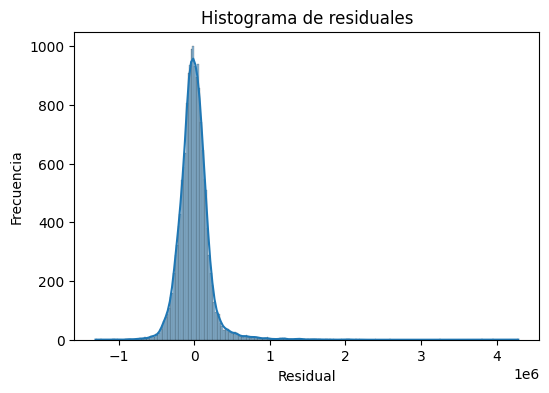

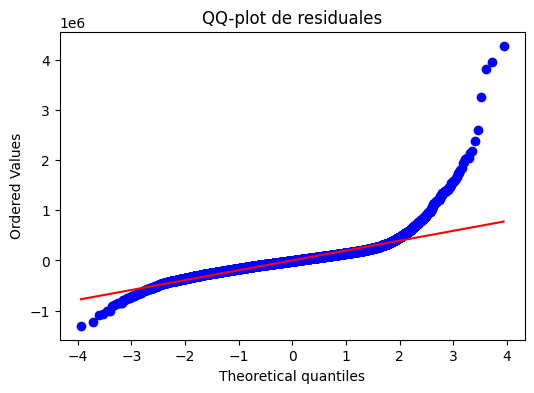

In [175]:
# Histograma
plt.figure(figsize=(6, 4))
sns.histplot(residuales, kde=True)
plt.title("Histograma de residuales")
plt.xlabel("Residual")
plt.ylabel("Frecuencia")
plt.show()

# 2. QQ-plot
plt.figure(figsize=(6, 4))
stats.probplot(residuales, dist="norm", plot=plt)
plt.title("QQ-plot de residuales")
plt.show()


Obtuvimos con la prueba de Shapiro–Wilk un $p-value$ $≈$ $7.9×10⁻⁸⁶$, prácticamente cero. Eso significa que desde el punto de vista estadístico, los errores no siguen una distribución normal.
Las gráficas nos permiten comprobar eso, por un lado el histograma muestra que aunque la mayoría de los errores se concentran cerca de 0, hay una cola muy larga hacia valores positivos grandes. Y en el QQ-plot los puntos se alejan bastante de la línea recta en los extremos.
Estos resultados muestran que el supuesto de normalidad no se cumple en el modelo. Esto, como en el caso anterior, no anula el modelo, sino que nos dice que no podemos hacer pruebas estadísticas como la $t$ o $F$ ni obtener conclusiones sobre los coeficientes de la regresión.


### Homecedasticidad

Este supuesto establece que los errores del modelo deben presentar una variabilidad aproximadamente constante para todos los niveles de las variables explicativas, es decir, que el modelo se equivoque de manera similar tanto en propiedades de bajo como de alto precio. Cuando este supuesto no se cumple, se presenta heterocedasticidad, lo que implica que los errores estándar de los coeficientes pueden estar mal estimados y, en consecuencia, las pruebas estadísticas `t` y `F` utilizadas para evaluar la significancia de las variables dejan de ser confiables. Una forma clásica de evaluar este supuesto es mediante la prueba de Breusch–Pagan.


In [176]:
X_num = Xt_train_df.select_dtypes(include="number").copy()
mask = np.isfinite(X_num).all(axis=1)
X_num_clean = X_num[mask]
resid_clean = residuales[mask]
X_num_const = sm.add_constant(X_num_clean)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(resid_clean, X_num_const)

print("Estadístico Breusch-Pagan:", bp_stat)
print("p-value Breusch-Pagan   :", bp_pvalue)

Estadístico Breusch-Pagan: 2098.506967341691
p-value Breusch-Pagan   : 0.0



La prueba de Breusch–Pagan nos da un estadístico $≈ 1898.86$ y un p-value $= 0.0$. Esto significa que desde el punto de vista estadístico la varianza de los errores no es constante, lo que significa que el modelo se equivoca con distinta intensidad según el tipo de observación.

Este resultados nos dicen que debemos ser cuidadosos al interpretar las pruebas de significancia de los coeficientes, porque sus errores estándar podrían estar subestimados o sobreestimados, llevándonos a errores de interpretación.


### Independencia de los errores

El supuesto de independencia dice que los errores del modelo no deberían estar conectados entre sí, basicamente que el error que comete el modelo en una observación no debería influir en el error de la siguiente.
En caso de que el supuesto no se cumpla, se tiene autocorrelación, que dice que los errores se mueven en grupo, haciendo que cualquier prueba estadística sea poco confiable.

Una forma de revisar el cumplimiento del supuesto es usando el estadístico de Durbin–Watson, que se comporta de esta forma:

$$0≤DW≤4$$

+ Si es $0$ o cercano, nos dice que hay problemas de autocorrelación positiva.
+ Si es $2$ significa que no hay autocorrelación (no hay problemas).
+ Si es $4$ o cercano, indica que hay problemas de autocorrelación negativa.
  

In [177]:
dw = durbin_watson(residuales)
print("Durbin-Watson:", dw)

Durbin-Watson: 2.015466265420121



El estadístico de Durbin–Watson es $≈ 2.02$, un valor muy cercano a $2$. Esto indica que no se detecta autocorrelación entre los errores.Esto nos dice que los errores se comportan como ruido más o menos independiente entre observaciones. Por lo tanto, con este resultado podemos considerar que el supuesto de independencia de los errores sí se cumple en el modelo.


### Gráficas para ver de manera visual la homocedasticidad e independencia de los residuos

<>:20: SyntaxWarning: "\h" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\h"? A raw string is also an option.
<>:43: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:20: SyntaxWarning: "\h" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\h"? A raw string is also an option.
<>:43: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
C:\Users\Profesor\AppData\Local\Temp\ipykernel_82736\4022646583.py:20: SyntaxWarning: "\h" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\h"? A raw string is also an option.
  plt.xlabel('Valores Ajustados ($\hat{y}$)')
C:\Users\Profesor\AppData\Local\Temp\ipykernel_82736\4022646583.py:43: SyntaxWarning: "\s" is an invalid escape sequence

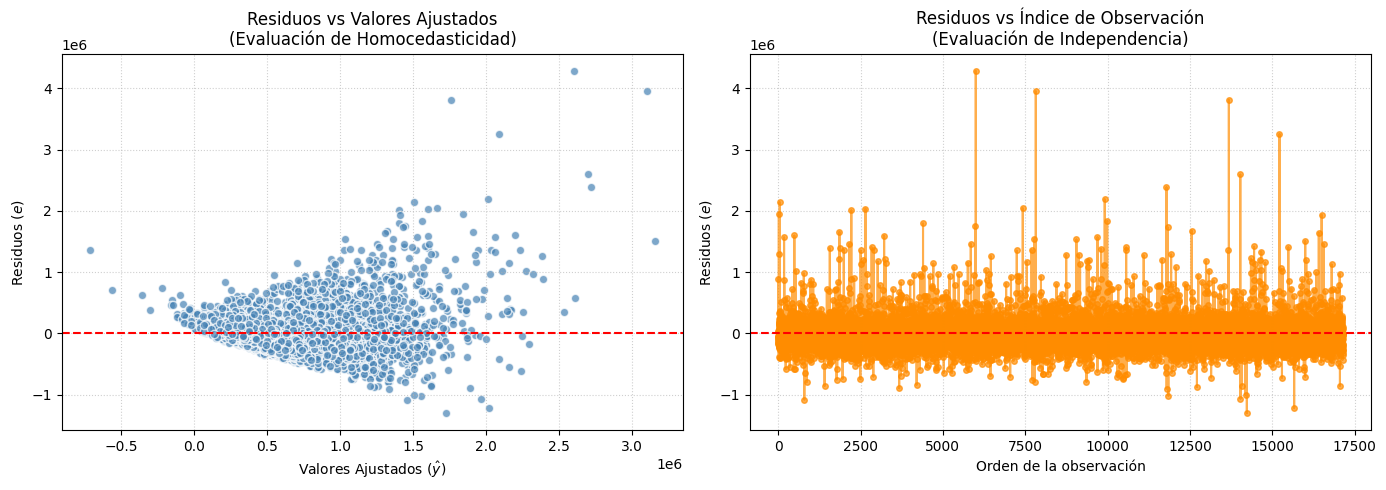

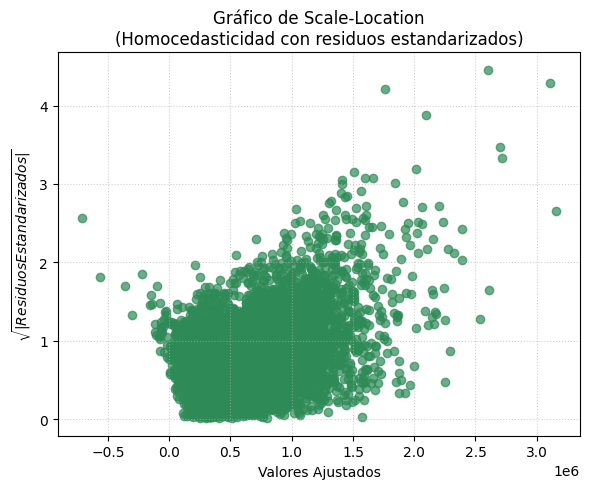

In [178]:
# Gráficas para ver de manera visual la homocedasticidad e independencia de los residuos

nombres_x = " + ".join(Xt_train_df.columns)

df_graficas=Xt_train_df.join(y_train)

# 2. Fit the linear regression model
model = ols(f'Precio ~ {nombres_x}', data=df_graficas).fit()
fitted_values = model.fittedvalues
residuals = model.resid

# Generación de las gráficas
plt.figure(figsize=(14, 5))

# Gráfica de Homocedasticidad
plt.subplot(1, 2, 1)
plt.scatter(fitted_values, residuals, alpha=0.7, color='steelblue', edgecolors='white')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuos vs Valores Ajustados\n(Evaluación de Homocedasticidad)')
plt.xlabel('Valores Ajustados ($\hat{y}$)')
plt.ylabel('Residuos ($e$)')
plt.grid(True, linestyle=':', alpha=0.6)

# Gráfica de Independencia
plt.subplot(1, 2, 2)
plt.plot(range(len(residuals)), residuals, marker='o', linestyle='-', markersize=4, alpha=0.7, color='darkorange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuos vs Índice de Observación\n(Evaluación de Independencia)')
plt.xlabel('Orden de la observación')
plt.ylabel('Residuos ($e$)')
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()
# plt.savefig('evaluacion_regresion.png')

# Scale-Location plot (optional but very useful for homoscedasticity)
plt.figure(figsize=(6, 5))
standardized_residuals = model.get_influence().resid_studentized_internal
plt.scatter(fitted_values, np.sqrt(np.abs(standardized_residuals)), alpha=0.7, color='seagreen')
plt.title('Gráfico de Scale-Location\n(Homocedasticidad con residuos estandarizados)')
plt.xlabel('Valores Ajustados')
plt.ylabel('$\sqrt{|Residuos Estandarizados|}$')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
# plt.savefig('scale_location.png')

### Linealidad

El supuesto de linealidad dice que la relación entre las variables explicativas y la media de `Precio` se puede describir razonablemente mediante una combinación lineal, es decir que cada variable aporta un efecto proporcional y más o menos constante sobre el precio cuando aumenta en una unidad, manteniendo las demás fijas.

Una forma de evaluar este supuesto es usar una prueba estadística como el test de Rainbow, que devuelve un estadístico y un p-value para comprobar si el modelo lineal se ajusta bien o si hay indicios de que la relación no es lineal.


In [179]:
X_sm = sm.add_constant(Xt_train_df)
modelo_sm = sm.OLS(y_train, X_sm).fit()

rainbow_stat, rainbow_pvalue = linear_rainbow(modelo_sm)

print("Estadístico Rainbow:", rainbow_stat)
print("p-value Rainbow    :", rainbow_pvalue)

Estadístico Rainbow: 1.0254424118850194
p-value Rainbow    : 0.12250450576952056



Tenemos que el test de Rainbow dio un estadístico $≈ 1.03$ y un $p-value$ $≈ 0.12$. El p-value es mayor que el umbral de $0.05$, lo que significa que no hay evidencia estadística para rechazar la linealidad, la prueba considera razonable que la relación entre las variables explicativas y el precio pueda describirse mediante un modelo lineal. Por lo que según esa información el supuesto se cumple.


## 9. Ejercicios

A continuación, realizaremos una serie de ejercicios prácticos cuyo objetivo es comprender cómo distintos cambios en la configuración del modelo afectan su entrenamiento y desempeño. Más allá de obtener resultados numéricos, la idea es que observes cómo y por qué cambian las métricas al modificar ciertos parámetros clave del proceso.
+ **Ejercicio 1. Proporción de datos de entrenamiento y prueba**.
Modifica el valor del parámetro test_size en la función `train_test_split` (por ejemplo, prueba con 0.1, 0.3 u otros valores). Ten en cuenta que una proporción de 0.2 es una práctica común y la utilizada inicialmente, pero experimentar con otros valores te permitirá analizar cómo influye la cantidad de datos disponibles para entrenamiento y evaluación en el rendimiento del modelo.
+ **Ejercicio 2. Efecto de la aleatoriedad (reproducibilidad)**.
Cambia el valor de random_state (por ejemplo, usa 1, luego 5 y luego 42) y ejecuta el modelo una vez con cada semilla. Observa cómo varían las métricas obtenidas. Posteriormente, selecciona un valor fijo de random_state y ejecuta el modelo tres veces con esa misma semilla. Reflexiona sobre la estabilidad de los resultados y la importancia de fijar la aleatoriedad para poder comparar experimentos de forma consistente.
+ **Ejercicio 3. Impacto del escalado de variables**.
Localiza en el pipeline el paso donde se aplica el StandardScaler y coméntalo temporalmente. Ejecuta nuevamente el modelo sin escalado y registra las métricas obtenidas. Luego, vuelve a activar el escalado y compara los resultados en ambos casos.¿Cambian las métricas de desempeño al escalar o no las variables? ¿Qué ocurre con los coeficientes del modelo en cada caso? ¿Por qué, aunque las métricas sean similares, el escalado sigue siendo útil desde el punto de vista de la interpretación?
+ **Ejercicio 4. Interpretación de coeficientes con y sin multicolinealidad**. Elimina una de las variables con VIF infinito (por ejemplo, AreaHabitable) y vuelve a entrenar el modelo. Compara los coeficientes antes y después de la eliminación. Observa si cambian los signos o magnitudes y analiza si las métricas cambian o se mantienen similares.

Nota: Sea consciente que puede utilizar cosas ya vistas en los notebooks de práctica anteriores.
